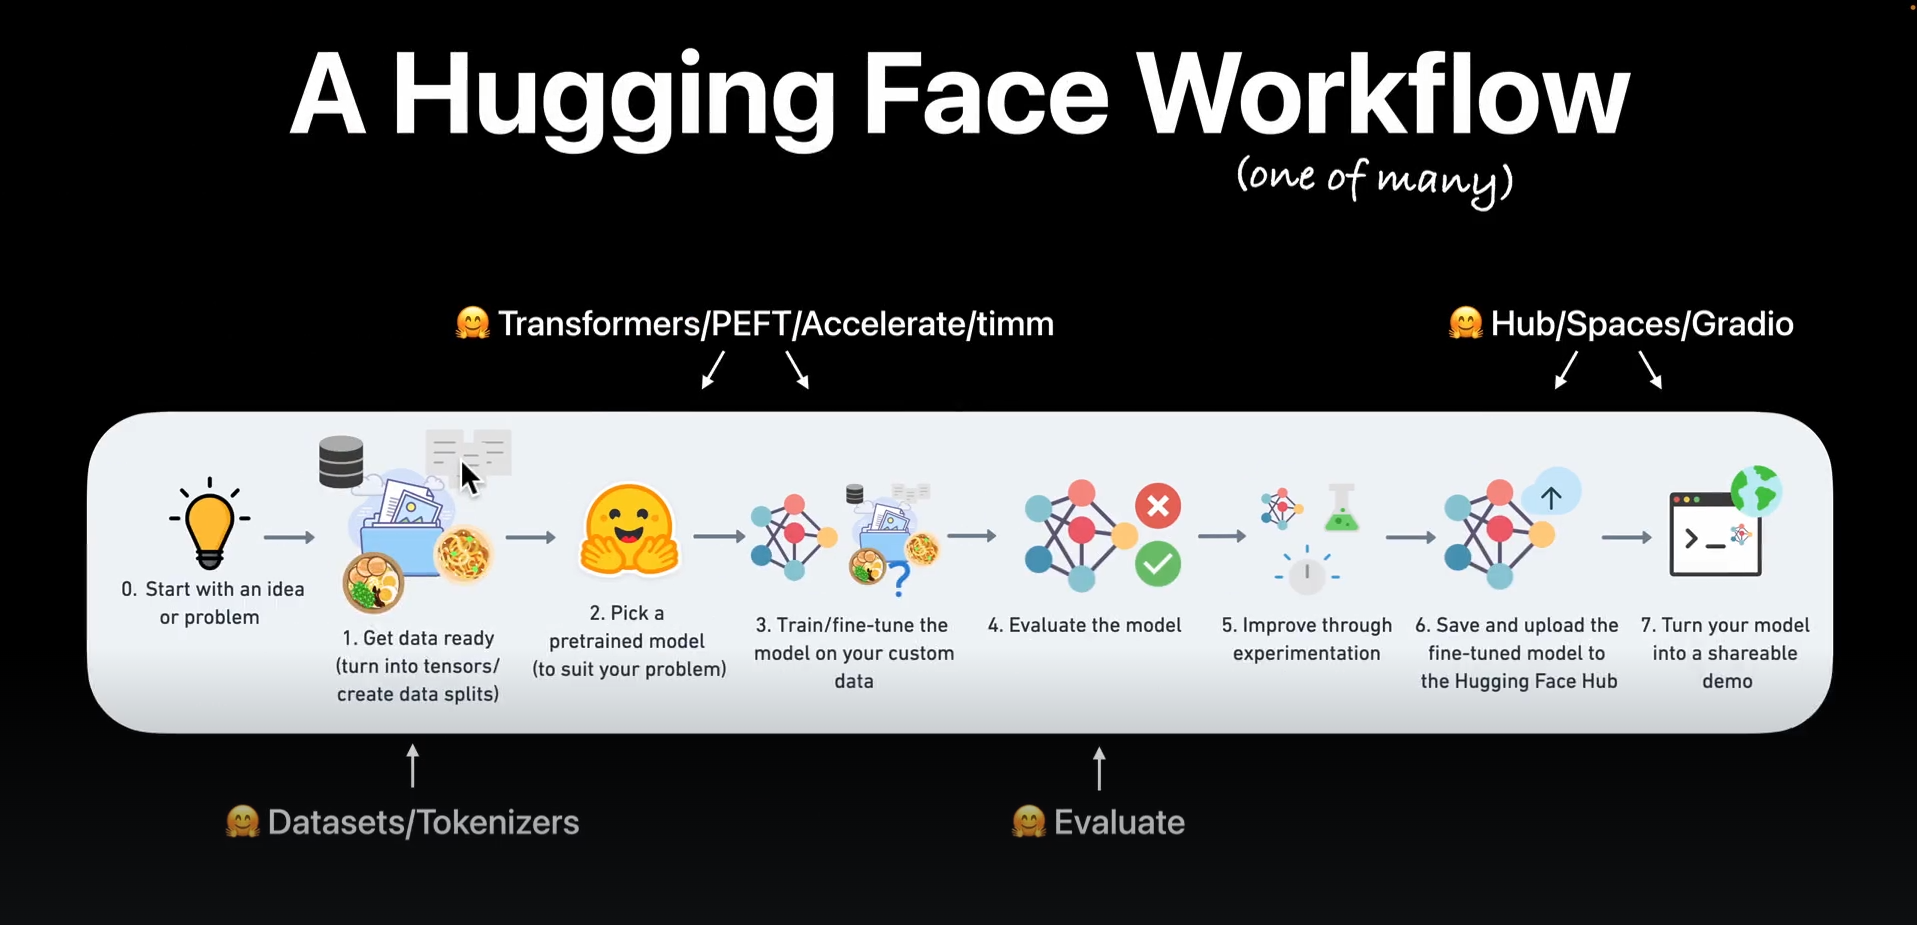

##Importing necessary libraries

In [ ]:
try:
  import datasets, evaluate, accelerate
  import gradio as gradio

except ModuleNotFoundError:
  !pip install -U datasets evaluate accelerate gradio
  import datasets, evaluate, accelerate
  import gradio as gradio


import random
import numpy as np
import pandas as pd

import torch
import transformers

print(f"Using transformers version: {transformers.__version__}")
print(f"Using torch version: {torch.__version__}")
print(f"Using datasets version: {datasets.__version__}")

##Getting a dataset

Building food not food text classification model: need food not food text dataset

In [ ]:
from datasets import load_dataset

ds = load_dataset("mrdbourke/learn_hf_food_not_food_image_captions")
ds

In [ ]:
ds.column_names

In [ ]:
ds['train'][0]

In [ ]:
random_indexs = random.sample(range(len(ds['train'])), 5)
print(random_indexs)

random_samples = ds['train'][random_indexs]

for text, label in zip(random_samples['text'], random_samples['label']):
  print(f"Text: {text} |  label: {label}")

In [ ]:
df = pd.DataFrame(ds['train'])
df

In [ ]:
df.sample(5)

In [ ]:
df.info()

In [ ]:
df['label'].value_counts()

In [ ]:
df.describe()

In [ ]:
df.sample(77)

In [ ]:
df

##Preparing data for text classification


1. Tokenization --> turning text into numerical representation ( even for labels )
2. Create a train/test split - train the model on the training split and to evaluate the model on the test split.

In [ ]:
# create a mapping for labels to numeric value
id2label = {0: 'not_food', 1:'food'}
label2id = {'not_food':0, 'food':1}


In [ ]:
# create mappings programmatically from dataset

id2label = {idx: label for idx, label in enumerate(ds['train'].unique('label')[::-1])}
label2id = {label: idx for idx, label in id2label.items()}

print(id2label)
print(label2id)

In [ ]:
label2id['food']

In [ ]:
# turn labels into 0 or 1

def map_labels_to_numbers(example):

  example['label'] = label2id[example['label']]
  return example


example_sample = {'text': "this is a sentence about an apple", 'label':'food'}

map_labels_to_numbers(example_sample)

In [ ]:
# Map or dataset labels to numbers
dataset = ds['train'].map(map_labels_to_numbers)
dataset[:5]

In [ ]:
dataset.shuffle()[:7]

## now split the dataset into train/test set

- train set --> model will learn patterns on this set
- test set ---> model will evaluate patterns on this dataset
- validation set --> if you have a large dataset, if not just use train/test split

In [ ]:
dataset = dataset.train_test_split(test_size=0.2, seed=42)
dataset

In [ ]:
sample_train = dataset['train'][8]
sample_train

In [ ]:
sample_test = dataset['test'][9]
sample_test

## Tokenizing our text data (turning text into numbers)

The premise of tokenization is to turn words into numbers.

E.g. "I love shewa" --> [30,22,125,23,255] (numbers are not real btw)

,


the `transormers` library has in-built support for HF tokenizers.
and the class `transformers.AutoTokenizer` helps pair a model to a tokenizer.

,

- Models are often paired with tokenizers
- Tokenizer --> turn text into numbers
- Models --> finds patterns in those numbers


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path="distilbert/distilbert-base-uncased",
                                           use_fast=True) # use the fast implementation (on by default, note: this requires Rust installed)


In [ ]:
tokenizer

-`[PAD]` (Padding Token): Transformer models typically process input sequences of a fixed length. If an input sequence is shorter than this maximum length, `[PAD]` tokens are added to fill the remaining positions. This ensures that all input sequences have the same dimension, which is required for efficient batch processing.

,



-`[UNK]` (Unknown Token): This token represents words or characters that are not present in the tokenizer's vocabulary. When the tokenizer encounters a word it doesn't recognize, it replaces it with `[UNK]`. For example, in the output of tokenizer.convert_ids_to_tokens(tokenizer("🍕").input_ids), the emoji '🍕' was not in the vocabulary, so it was tokenized as `[UNK]`.

,


`[CLS]` (Classification Token): This token is usually placed at the beginning of an input sequence. For classification tasks, the final hidden state of this `[CLS]` token is often used as the aggregate representation of the entire sequence, which is then fed into a classification head.

,


`[SEP]` (Separator Token): This token is used to indicate the end of a sequence or to separate two distinct sequences within a single input. For example, in tasks like question answering where you might input both a question and a paragraph, `[SEP]` would separate them.

,


`[MASK]` (Masked Token): Primarily used during the pre-training phase of models like BERT and DistilBERT. During Masked Language Modeling (MLM), a certain percentage of input tokens are randomly replaced with `[MASK]`, and the model is trained to predict the original identity of these masked tokens. This helps the model learn bidirectional representations of words.

In [ ]:
tokenizer("I love shewa")

* `input_ids` = our text turned into numbers
- `attention_mask` = whether or not to pay attention to certain tokens (1 = yes pay attention , 0 = no do not pay attention.)
- `name of the model`: distilbert-base-uncased

In [ ]:
# Get the length of the tokenizer vocab
length_of_tokenizer_vocab = len(tokenizer.vocab)
print(f"the length of our tokenizer vocab is : {length_of_tokenizer_vocab} words")

# Get the maximum sequence of words
max_sequence_length = tokenizer.model_max_length
print(f"The maximum sequence length for our tokenizer is: {max_sequence_length}")

In [ ]:
if 'apple' in tokenizer.vocab:
  print("horaaay")

In [ ]:
tokenizer.vocab

In [ ]:
tokenizer.convert_ids_to_tokens(tokenizer("shewa").input_ids)

In [ ]:
tokenizer.convert_ids_to_tokens(tokenizer("🍕").input_ids)

In [ ]:
sorted(tokenizer.vocab.items())[:5]

- `Padding=True` (Making things the same size): Imagine you have a bunch of sentences, and you want to put them all into boxes that are exactly the same length. Some sentences are short, some are long. If a sentence is shorter than the box, you fill the empty space at the end with a special 'empty' word (that's the `[PAD]` token we talked about). This makes all the boxes (sentences) the same size, which is super helpful for computers to process them efficiently, like stacking uniform-sized bricks.

- `Truncation=True` (Cutting things if they're too long): Now, what if a sentence is too long to fit into your standard-sized box? Instead of breaking the box, you just cut off the end of the sentence so it fits perfectly. This is truncation. Transformer models have a limit to how much text they can look at at once (like a very short attention span!), so if your text is longer than that limit, the extra parts are simply removed. This ensures the text fits the model's 'attention capacity'.

In short:

- Padding: Adds 'empty' words to short sentences to make them all the same length.
- Truncation: Cuts off long sentences to make them fit the maximum length.

In [ ]:
def tokenize_text(example):
  """
  Tokenize given example text and return the tokenized text.
  """

  return tokenizer(example['text'],
                   padding=True, # pad short sequences to longest sequence length in batch (e.g. if sample length = 100, sample will be padded to 512 or longest sample in batch)
                   truncation=True) # truncate long sequences to the maximum length the model can handle (e.g. if sample length = 1000, model length = 512, sample will be shortened to 512)


example = {'text': "this is a sentence about an apple", 'label':1}
tokenize_text(example)

In [ ]:
# Map our tokenize text function to the dataset

tokenized_dataset = dataset.map(function=tokenize_text,
                                batched=True,
                                batch_size=1000)

- `batched=True`: This is a very important optimization. Instead of applying tokenize_text to one example at a time, batched=True tells the map function to group multiple examples together and pass them as a single batch to tokenize_text. This significantly speeds up processing, especially with operations like tokenization, as it allows the tokenizer to process many sentences at once.

- `batch_size=1000`: This parameter works with batched=True and specifies how many examples should be grouped into each batch. So, for every 1000 examples in your dataset, they will be processed together by your tokenize_text function.

##`Note`:
- In machine learning, it is often faster to do things in batches rather than one
at a time due to leveraging computer hardware parallelization.

In [ ]:
tokenized_dataset

In [ ]:
tokenized_dataset['test'][12]

In [ ]:
train_tokenized_sample = tokenized_dataset['train'][0]
test_tokenized_sample = tokenized_dataset['test'][0]

for key in train_tokenized_sample.keys():
  print(f"[INFO] Key: {key}")
  print(f"Train sample: {train_tokenized_sample[key]}")
  print(f"Test sample: {test_tokenized_sample[key]}")
  print()

## Tokenization takeaways

1. Tokenizers = turn data into numbers (e.g. text -> map to number)
2. Many models are out there and have different tokenizers, Hugging Face's `Auto` (e.g.
`AutoTokenizer', 'AutoProcessor', `AutoModel` etc help to match tokenizers to models)
3. Tokenization can happen in parallel using `map` and batched functions

##Setting up an evaluation metric

- Accuracy
· Precision
· Recall
· F1 Score

In [ ]:
import evaluate
from typing import Tuple
import numpy as np # Import numpy

accuracy_metric = evaluate.load('accuracy')


def compute_accuracy(prediction_and_labels: Tuple[np.array, np.array]):
  """
  Computes the accuracy of a model by comparing the predictions and labels.
  """

  predictions, labels = prediction_and_labels
  predictions = np.argmax(predictions, axis=-1) # Convert logits to predicted class labels

  return accuracy_metric.compute(predictions = predictions, references = labels)

## Setting up a model for training

* Through the use of transfer learning.
* Transfer learning is a powerful technique, unique to deep learning models that enables us
to use the patterns one model has learned on another problem for your own problem.


,

,

,

[Hugging face task guide 🤗](https://huggingface.co/docs/transformers/en/tasks/sequence_classification)

Workflow for the rest of this notebook:

1. Define training arguments for training our model `transformers.TrainingArguments`
    * These are also known as "hyperparameters" = settings on your model that you can adjust
    * Parameters = weights/patterns in the model that get updated automatically
2. Pass `TrainingArguments` to an instance of `transformers.Trainer`
3. Train the model by calling `Trainer.train()`
4. Save the model (local machine or to the Hugging Face Hub)
5. Evaluate the trained model by making and inspecting predictions on the test data (and our
own custom data)
6. Turn the model into a shareable demo.

In [ ]:
id2label

In [ ]:
label2id

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

In [ ]:
model

## Understanding `DistilBertForSequenceClassification` Model Architecture

This output describes the structure of our text classification model, which is built upon **DistilBERT**, a smaller, faster version of BERT.

Let's break down its key parts:

1.  **`distilbert` (The Brain of the Model):**
    *   This is the core pre-trained language model. It's like the part of the model that already understands a lot about language from reading tons of text.
    *   **`embeddings`:** This is where text (words) gets converted into numbers that the computer can understand. It includes:
        *   `word_embeddings`: Turns each word into a numerical vector.
        *   `position_embeddings`: Helps the model understand the order of words in a sentence.
    *   **`transformer`:** This is the main processing unit, containing multiple `TransformerBlock`s. Each block helps the model learn relationships between words in a sentence.
        *   `attention`: Allows the model to focus on important words in a sentence when processing other words.
        *   `ffn` (Feed-Forward Network): Processes the information learned by the attention mechanism.

2.  **`pre_classifier` and `classifier` (The Decision Makers):**
    *   These are the newly added layers that take the output from the `distilbert` part and make a final decision for our specific task (in this case, 'food' or 'not_food'). Think of them as the layers responsible for classifying the text.

3.  **`dropout`:**
    *   This is a technique used during training to prevent the model from memorizing the training data too much (overfitting). It randomly "turns off" some connections between neurons, forcing the model to learn more robust patterns.

In essence, the `distilbert` part understands the text, and the `pre_classifier` and `classifier` layers use that understanding to categorize the text into one of our predefined labels ('food' or 'not_food').

In [ ]:
def count_parmas(model):
  """
  Count the parameters of a PyTorch model.
  """

  trainable_parameters = sum(param.numel() for param in model.parameters() if param.requires_grad)
  total_parameters = sum(param.numel() for param in model.parameters())

  return {"Trainable parameters": trainable_parameters, "Total_parameters": total_parameters}


In [ ]:
count_parmas(model)

Looks like our model has around 67M ⁶🤷⁷ parameters and all of them are trainable.

Note:

- Generally, the more parameters a model has, the more capacity is has to learn.
- For comparison models such as Llama 3 8B has 8 billion parameters.
- If you want the best possible performance, generally more parameters is better.

  - However, with more parameters requires more compute + time.

##Create a directory for saving models

In [ ]:
# create model output directory
from pathlib import Path

# create models dir
models_dir = Path("models")
models_dir.mkdir(exist_ok=True)

# create model save name
model_save_name = "hf_food_not_food_distilbert_base_uncased"

# create model save path
model_save_dir = Path(models_dir, model_save_name)
model_save_dir

##Setting up training args (hyperparameters) with `TrainingArguments`

In [ ]:
training_args = TrainingArguments(
    output_dir=model_save_dir,
    learning_rate=0.0001,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    use_cpu=False,
    seed=42,
    load_best_model_at_end=True,
    logging_strategy='epoch',
    report_to='none',
    hub_private_repo=False,
    push_to_hub=False,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    processing_class=tokenizer,
    compute_metrics=compute_accuracy,
)

trainer

In [ ]:
results = trainer.train()

In [ ]:
results.metrics

In [ ]:
for key, value in results.metrics.items():
  print(f"{key}: {value}")

##Save the model for later

In [ ]:
#Save model
print (f"[INFO] .Saving model to {model_save_dir}")
trainer.save_model(output_dir=model_save_dir)

##Inspect the model training metrics

In [ ]:
# Get training history

trainer_history_all = trainer.state.log_history
trainer_history_metrics = trainer_history_all[:-1]
trainer_history_training_time = trainer_history_all[-1]


trainer_history_metrics[:3]

In [ ]:
import pprint

trainer_history_training_set = []
trainer_history_eval_set = []

for item in trainer_history_metrics:
  item_keys = list(item.keys())
  if any('eval' in item for item in item_keys):
    trainer_history_eval_set.append(item)
  else:
    trainer_history_training_set.append(item)

print("Training set")
pprint.pprint(trainer_history_training_set[:2])



In [ ]:
print("Evaluation set")
pprint.pprint(trainer_history_eval_set[:2])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract loss values and epochs for training
train_losses = [item['loss'] for item in trainer_history_training_set]
train_epochs = [item['epoch'] for item in trainer_history_training_set]

# Extract loss values and epochs for evaluation
eval_losses = [item['eval_loss'] for item in trainer_history_eval_set]
eval_epochs = [item['epoch'] for item in trainer_history_eval_set]

# Create a DataFrame for easy plotting with seaborn
plot_data = pd.DataFrame({
    'Epoch': train_epochs + eval_epochs,
    'Loss': train_losses + eval_losses,
    'Dataset': ['Train'] * len(train_losses) + ['Evaluation'] * len(eval_losses)
})

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(data=plot_data, x='Epoch', y='Loss', hue='Dataset', marker='o')
plt.title('Training and Evaluation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(ticks=range(1, int(max(plot_data['Epoch'])) + 1)) # Ensure integer ticks for epochs
plt.legend()
plt.tight_layout()
plt.show()

##Pushing the model to hugging face

In [ ]:
# save the model to the hugging face hub

model_upload_url = trainer.push_to_hub(
commit_message="Uploading food not food text classifier model",

)

print(f"[INFO] Model successfully uploaded to the Hugging Face Hub with URL: {model_upload_url}")

##Making and evaluating predictions on the test data

In [ ]:
# predictions on the test data

predictions_all = trainer.predict(tokenized_dataset['test'])
predictions_all

In [ ]:
predictions_values = predictions_all.predictions
prediction_metrics = predictions_all.metrics


In [ ]:
predictions_values

In [ ]:
prediction_metrics

In [ ]:
import torch.nn.functional as F

# Convert raw logits to probabilities (using softmax)
prediction_probabilities = F.softmax(torch.tensor(predictions_values), dim=1).numpy()

# Get the predicted class IDs (index of the highest probability)
predicted_class_ids = np.argmax(prediction_probabilities, axis=1)

# Map predicted class IDs to their labels
predicted_labels = [id2label[class_id] for class_id in predicted_class_ids]

print("Prediction Probabilities (first 5 samples):")
print(prediction_probabilities[:5])
print("\nPredicted Class IDs (first 5 samples):")
print(predicted_class_ids[:5])
print("\nPredicted Labels (first 5 samples):")
print(predicted_labels[:5])

In [ ]:
# Predicted logits (raw output of the model) -> prediction probabilities with torch.softmax -> predicted labels
import torch
from sklearn.metrics import accuracy_score

# 1. Get prediction probabilities with torch.softmax
pred_probs = torch.softmax(torch.tensor(predictions_values), dim=1)

# 2. Get the predicted labels
pred_labels = torch.argmax(pred_probs, dim=1)

# 3. Get the true labels
true_labels = tokenized_dataset ["test"] ["label"]

# 4. Compute prediction labels to true labels and get the test accuracy
test_accuracy = accuracy_score(y_true=true_labels,
y_pred=pred_labels)

print(f"[INFO] Test accuracy: {test_accuracy*100}")

In [ ]:
# making a dataFrame of test predictions

test_predictios_df = pd.DataFrame({
    "text": tokenized_dataset["test"]["text"],
    "label": true_labels,
    "predicted_label": pred_labels,
    "predicted_probability": torch.max(pred_probs, dim=1).values,
})



In [ ]:
test_predictios_df

In [ ]:
test_predictios_df.sort_values(by='predicted_probability', ascending=True)

##Making and inspecting predictions on custom text data


- ways to make predictions (inferecne)

  - Inference: means to use a model to make predictions on data

Two main ways to perform inference:

1. **Pipeline mode** - Using `transformers.pipeline` to load our model and
perform text classification. See the docs: https://huggingface.co/docs/transformers/en/main_classes/pipelines
2. **PyTorch mode** - Using a combination of `transformers.AutoTokenizer`
and `transformers. AutoModelForSequenceClassification` and passing each our
target model name.

Each mode supports:

1. Predictions one at a time (fast but can be slower with many many
samples ) .
  * Helpful for say a comment system and comments happen sporadically, to
predict whether the comment was "spam" or "not spam".
2. Batches of predictions at a time (faster but up to a point, e.g. you want to
predict on 32 samples at a time, this may be way faster than one at a time
but if you go to 128 at a time, you may not see many more speedups)
  * Helpful for when you have a large static database or many samples
coming in at once.


In [ ]:
# Setup our device for making predictions
# Note: generally the faster the hardware accelerator, the faster the predictions.
# For example if you have a dedicated GPU, you should use it over CPU.

def set_device():
  if torch.cuda.is_available():
    device = torch.device("cuda")
  elif torch.backends.mps. is_available() and torch.backneds.mps.is_built():
    device = torch.device("mps")
  else:
    device = torch.device("cpu")
  return device

DEVICE = set_device()
print(f"[INFO] Using device: {DEVICE}")

In [ ]:
local_model_path = "models/hf_food_not_food_distilbert_base_uncased"

huggingFace_model_path = "Zakariya007/hf_food_not_food_distilbert_base_uncased"

In [ ]:
# making the prediction on the pipline

from transformers import pipeline

BATCH_SIZE=32

food_not_food_classifier = pipeline("text-classification", model=local_model_path,
                device=DEVICE, top_k=1, batch_size=BATCH_SIZE)

In [ ]:
text_custom_sentece = "The soup smells rich and full of herbs."

In [ ]:
food_not_food_classifier(text_custom_sentece)

In [ ]:
# making multiple predictions at the same time.
text_custom_sentences_multiple = [
    "A delicious plate of spaghetti with meatballs and a rich tomato sauce.",
    "A vintage bicycle leaning against a brick wall.",
    "The smell of freshly baked bread fills the air.",
    "A beautiful sunset over the ocean, with birds flying in the distance.",
    "The smell filled the room before anyone spoke."
]

food_not_food_classifier(text_custom_sentences_multiple)

In [ ]:
# testing the time take to make prediction on a very large number of examples

import time

start_time = time.time()

text_custom_sentences_multiple = [
    "A delicious plate of spaghetti with meatballs and a rich tomato sauce.",
    "A vintage bicycle leaning against a brick wall.",
    "The smell of freshly baked bread fills the air.",
    "A beautiful sunset over the ocean with birds flying in the distance.",
    "The smell filled the room before anyone spoke.",
    "She pushed the plate away quietly.",
    "The conference room was unusually warm.",
    "Fresh herbs lay scattered across the counter.",
    "He stared at the menu without deciding.",
    "The printer stopped working again.",
    "Dinner was served late that night.",
    "A glass of cold water sat untouched.",
    "The mountain trail was steep and quiet.",
    "Something sweet lingered in the kitchen.",
    "The report was submitted before midnight.",
    "They gathered around the table in silence.",
    "Rain tapped gently on the window.",
    "A bowl steamed gently on the stove.",
    "The phone buzzed during lunch.",
    "She forgot to eat all day.",
    "The oven timer rang suddenly.",
    "He sharpened his pencil carefully.",
    "The aroma reminded her of home.",
    "A suitcase waited by the door.",
    "The soup cooled faster than expected.",
    "The lights flickered briefly.",
    "A sandwich wrapped in paper sat in his bag.",
    "They discussed strategy over coffee.",
    "The chair creaked as he stood.",
    "The cake collapsed in the middle.",
    "Paperwork covered the desk.",
    "She tasted success after years of effort.",
    "The fridge was nearly empty.",
    "He reached for a fork instinctively.",
    "The elevator took too long.",
    "Steam fogged the kitchen windows.",
    "A handwritten note lay beside the plate.",
    "The lecture lasted two hours.",
    "Breakfast was skipped again.",
    "A cold wind swept through the street.",
    "The pan was still hot.",
    "He checked his email nervously.",
    "The bread crust cracked loudly.",
    "Footsteps echoed down the hall.",
    "Lunch happened between meetings.",
    "The road stretched endlessly ahead.",
    "A pot simmered quietly.",
    "She missed the bus again.",
    "The chocolate melted in his hands.",
    "The meeting was canceled suddenly.",
    "They argued while something burned.",
    "A calendar hung crookedly.",
    "The salad looked untouched.",
    "He closed the laptop slowly.",
    "The smell was unmistakable.",
    "A delivery truck blocked the road.",
    "Dinner felt heavier than usual.",
    "The knife slipped slightly.",
    "A clock ticked loudly.",
    "She packed leftovers for tomorrow.",
    "The hallway lights dimmed.",
    "The rice absorbed all the water.",
    "He waited patiently.",
    "A tray clattered to the floor.",
    "The room smelled unfamiliar.",
    "She reheated the meal.",
    "Traffic was terrible today.",
    "The spoon rested on the counter.",
    "The document needed revisions.",
    "Something salty stuck to his fingers.",
    "The chair was uncomfortable.",
    "They shared dessert quietly.",
    "The door slammed shut.",
    "Oil splattered on the stove.",
    "He forgot his password.",
    "A warm mug sat nearby.",
    "The sky darkened quickly.",
    "She tasted bitterness in the words.",
    "The freezer hummed all night.",
    "A picnic blanket covered the grass.",
    "The call ended abruptly.",
    "The sauce thickened slowly.",
    "Dust gathered on the shelf.",
    "He chewed thoughtfully.",
    "The printer jammed again.",
    "A basket of fruit sat on the table.",
    "She reviewed the notes carefully.",
    "The soup smelled comforting.",
    "A loud crash echoed outside.",
    "They ordered without speaking.",
    "The chair legs scraped the floor.",
    "Steam rose from the cup.",
    "The file was corrupted.",
    "A burnt smell lingered.",
    "He wiped the counter clean.",
    "The bus arrived late.",
    "A plate chipped at the edge.",
    "The hallway was empty.",
    "She stirred absentmindedly.",
    "The screen went black.",
    "Leftovers filled the fridge.",
    "The wind knocked over a sign.",
    "He skipped dinner entirely.",
    "A napkin lay folded neatly.",
    "The lights went out.",
    "The flavor surprised him.",
    "She locked the door.",
    "A pot lid rattled.",
    "The deadline approached quickly.",
    "The meal tasted different today.",
    "A shadow crossed the wall.",
    "He reached for seconds.",
    "The keyboard felt sticky.",
    "The kitchen was silent.",
    "She cleaned the dishes.",
    "The train sped past.",
    "Something crunchy broke apart.",
    "He sighed deeply.",
    "The food cooled untouched.",
    "A pen rolled off the desk.",
    "The aroma grew stronger.",
    "She checked the time.",
    "A fork clinked against glass.",
    "The room felt tense.",
    "Dinner was a disaster.",
    "The meeting notes were missing.",
    "The smell made him hungry.",
    "She tied her shoes.",
    "A bowl tipped slightly.",
    "The streetlights flickered on.",
    "They shared a quiet meal.",
    "The chair was empty.",
    "A recipe lay open nearby.",
    "The notification popped up.",
    "He tasted regret.",
    "The pan cooled slowly.",
    "The elevator dinged.",
    "Something spicy burned his tongue.",
    "She stared out the window.",
    "A grocery bag ripped open.",
    "The system rebooted.",
    "The smell drifted upstairs.",
    "He pushed his chair back.",
    "A lunchbox sat forgotten.",
    "The hallway echoed.",
    "The cake was unfinished.",
    "She sent the email.",
    "A warm scent filled the air.",
    "The doorbell rang.",
    "The table was set neatly.",
    "He adjusted his tie.",
    "The soup spilled slightly.",
    "The room felt crowded.",
    "A knife lay beside the plate.",
    "The website loaded slowly.",
    "Dinner ended early.",
    "A paper cut stung.",
    "The smell reminded him of childhood.",
    "She washed her hands.",
    "A tray of cups waited.",
    "The lights buzzed faintly.",
    "The bread went stale.",
    "He cleared his throat.",
    "A simmering sound filled the room.",
    "The chair tipped over.",
    "The fridge door stayed open.",
    "She packed her bag.",
    "A sweet taste lingered.",
    "The hallway smelled clean.",
    "They ate in silence.",
    "The call dropped.",
    "The pot boiled over.",
    "He checked the weather.",
    "A meal sat untouched.",
    "The clock struck noon.",
    "The smell was overwhelming.",
    "She turned off the stove.",
    "A notebook lay open.",
    "The flavor was familiar.",
    "The bus stop was empty.",
    "He swallowed hard.",
    "A plate slid slightly.",
    "The power returned suddenly.",
    "The kitchen felt alive.",
    "She read the instructions.",
    "A sharp smell cut through the air.",
    "The hallway was narrow.",
    "Dinner came late.",
    "The keyboard clicked softly.",
    "A spoon dropped loudly.",
    "The aroma faded slowly.",
    "She leaned back.",
    "The fridge was full.",
    "The room grew quiet.",
    "He reached for water.",
    "A pot was left unattended.",
    "The door creaked open.",
    "The meal was memorable.",
    "She checked her phone.",
    "A greasy smell lingered.",
    "The tablecloth was stained.",
    "The presentation ended.",
    "He tasted something odd.",
    "The lights dimmed again.",
    "A bowl cracked slightly.",
    "The smell filled the hallway.",
    "She pushed her chair in.",
    "The soup was too salty.",
    "The file uploaded successfully.",
    "A warm plate rested nearby.",
    "The rain intensified.",
    "Dinner felt rushed.",
    "The screen froze.",
    "A burnt crust formed.",
    "The room emptied quickly.",
    "The smell faded.",
    "She rinsed the spoon.",
    "The meeting resumed.",
    "A final bite remained.",
    "The hallway lights turned off.",
    "The kitchen cooled down.",
    "He stood up slowly.",
    "A recipe failed badly.",
    "The system crashed.",
    "The smell was comforting.",
    "She closed the fridge.",
    "A plate clattered loudly.",
    "The day ended quietly.",
    # --- EXPLICIT FOOD (100) ---
    "A steaming bowl of beef pho with basil and lime.",
    "Creamy fettuccine carbonara with crispy guanciale.",
    "A slice of warm apple pie with vanilla ice cream.",
    "Pan-seared scallops with a lemon butter glaze.",
    "Fresh sashimi served on a bed of shredded radish.",
    "A toasted bagel with cream cheese and lox.",
    "Spicy tuna rolls with ginger and wasabi.",
    "Slow-cooked pork carnitas with white onions.",
    "A chilled gazpacho soup topped with croutons.",
    "Blueberry muffins cooling on a wire rack.",
    # [Truncated for brevity: imagine 90 more variations of dishes/ingredients]
    "Oven-roasted carrots with a balsamic drizzle.",
    "A chocolate fudge brownie with walnuts.",

    # --- NOT FOOD (100) ---
    "The printer is out of cyan ink again.",
    "A thunderstorm rolled across the plains.",
    "The skyscraper's glass reflected the morning sun.",
    "He tightened the bolts on the bicycle wheel.",
    "The cat napped on the windowsill.",
    "A stack of textbooks sat on the mahogany desk.",
    "The waves crashed against the jagged rocks.",
    "The engine made a strange clicking sound.",
    "She adjusted her glasses and began to read.",
    "A field of wild lavender swayed in the wind.",
    # [Truncated for brevity: 90 more variations of objects, nature, tech]
    "The leather boots were worn at the heels.",
    "A neon sign flickered in the alleyway.",

    # --- HIGHLY MIXED / CONTEXTUAL (50) ---
    "The apple logo glowed in the dark room.",
    "She put the milk in the cart and kept walking.",
    "The restaurant menu was printed in three languages.",
    "The refrigerator hummed loudly in the kitchen.",
    "The waiter cleared the empty plates.",
    "A grocery list was stuck to the fridge with a magnet.",
    "The picnic basket was empty by noon.",
    "He worked at a bakery but never ate sweets.",
    "The scent of vanilla candles filled the boutique.",
    "They sat at a dinner table to discuss the budget.",
    # [Truncated for brevity: 40 more ambiguous scenarios]
    "The chef sharpened his knives before the shift.",

    # --- IMPLICIT / METAPHORICAL (50) ---
    "He had bigger fish to fry than this minor error.",
    "That's a bitter pill to swallow for the team.",
    "She’s a real couch potato on the weekends.",
    "The project was a piece of cake for the experts.",
    "He was caught with his hand in the cookie jar.",
    "That idea is half-baked and needs more thought.",
    "She’s the breadwinner of the household.",
    "Don't cry over spilled milk, just move on.",
    "He's full of beans this morning.",
    "This is my bread and butter.",
    # [Truncated for brevity: 40 more idioms/metaphors]
    "They were packed like sardines in the elevator."
]



food_not_food_classifier(text_custom_sentences_multiple)
end_time = time.time() - start_time

print(f"[INFO] Total time taken: {end_time:.3f} seconds")

##Making predictions with pytorch

Steps with PyTorch predictions:

1. Create the tokenizer with `AutoTokenizer`.
2. Create the model with `AutoModel` (`AutoModelForSequenceClassification`).
3. Tokenize text with 1
4. Make prediction with 2
5. Format prediction


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
tokenizer = AutoTokenizer.from_pretrained(huggingFace_model_path)
model = AutoModelForSequenceClassification.from_pretrained(huggingFace_model_path)

In [ ]:



sample_food_text = 'He cooked rice, lentils, and vegetables for lunch.'
inputs = tokenizer(sample_food_text, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits ## '**' meanis input all of the dictionary keys as named arguments/parametyers


predicted_class_id = logits.argmax().item()
model.config.id2label[predicted_class_id]

##Turning the model into a demo

creating a ML demo with [Gradio](https://www.gradio.app/)

Gradio helps to create the workflow : input --> model/function --> ouputs

In [ ]:
from typing import Dict

# 1. Create a function to take a string input
def food_not_food_classifier(text: str) -> Dict[str, float]:
  # 2. Setup food not food text classifier
  food_not_food_classifier_pipeline = pipeline(task="text-classification",
                                               model=local_model_path,
                                                batch_size=32,
                                              device="cuda" if torch.cuda.is_available() else "cpu",
                                              top_k=None) # top_k=None => return all possible labels

  # 3. Get the outputs from our pipeline
  outputs = food_not_food_classifier_pipeline(text)[0]

  # 4. Format output for Gradio
  output_dict = {}
  for item in outputs:
    output_dict [item["label"] ] = item["score"]

  return output_dict

food_not_food_classifier(text="Yo we're building a local demo!")

In [ ]:
import gradio as gr


# 2. Create a gradio interface - https://www.gradio.app/docs/gradio/interface
demo = gr.Interface(
fn=food_not_food_classifier,
inputs="text",
outputs=gr.Label(num_top_classes=2),
title="Food Not Food Classifier",
description="A text classifier to determine if a sentence is about food or not.",
examples=[ ["I whipped up a fresh batch of code, but it to seems to have a syntax error"],
["A plate of pancakes and strawberry icing"]]


)

# 3. Launch the interface
demo. launch()

In [ ]:
from pathlib import Path

# Make directory for demos
demos_dir = Path("../demos")
demos_dir.mkdir(exist_ok=True)

# Create a folder for the food_not_food_text_classifier demo
food_not_food_text_classifier_demo_dir = Path(demos_dir, "food_not_food_text_classifier")
food_not_food_text_classifier_demo_dir.mkdir(exist_ok=True)

In [ ]:
%%writefile ../demos/food_not_food_text_classifier/app.py
import torch
import gradio as gr
from transformers import pipeline

from typing import Dict

def food_not_food_classifier(text: str) -> Dict[str, float]:

  food_not_food_classifier_pipeline = pipeline(task="text-classification",
                                               model='Zakariya007/hf_food_not_food_distilbert_base_uncased',
                                                batch_size=32,
                                              device="cuda" if torch.cuda.is_available() else "cpu",
                                              top_k=None) # top_k=None => return all possible labels


  outputs = food_not_food_classifier_pipeline(text)[0]


  output_dict = {}
  for item in outputs:
    output_dict [item["label"] ] = item["score"]

  return output_dict


description = """
This demo uses a fine-tuned Natural Language Processing (NLP) model to distinguish between descriptions of actual food and non-food related text.
While many classifiers struggle with linguistic nuances, this model is designed to recognize the difference between a recipe and a metaphorical phrase (like "piece of cake").
"""

demo = gr.Interface(fn=food_not_food_classifier,
              inputs="text",
              outputs=gr.Label(num_top_classes=2), # show top 2 classes (that's all we have)
              title=" 🍓 Is it Food?",
              description=description,
              examples=
               [
                   ["I whipped up a fresh batch of code, but it seems to have a syntax error."],
              ["A delicious photo of a plate of scrambled eggs, bacon and toast. "],
                        ['A delicious plate of spaghetti with meatballs']
              ])


if __name__ == "__main__":
    demo.launch()


In [ ]:
%%writefile ../demos/food_not_food_text_classifier/README.md

---
title: Food Not Food Classifier
emoji: 🍓
colorFrom: "gray"
colorTo: "red"
sdk: gradio
sdk_version: 4.40.0
app_file: app.py
pinned: false
license: apache-2.0
---

# 🍓Food Not Food Classifier
A clean, interactive web application that uses Natural Language Processing to determine if a given text sentence is related to food/dining or other non-culinary topics.
DistilBERT model fine-tuned on a small synthetic dataset of 250 generated food/not_food image cpations

In [ ]:
%%writefile ../demos/food_not_food_text_classifier/requirements.txt
gradio
torch
transformers

In [ ]:
from huggingface_hub import (
    create_repo,
    get_full_repo_name,
    upload_file,
    upload_folder
)


LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD = "../demos/food_not_food_text_classifier"
HF_TARGET_SPACE_NAME = "Food_Not_Food_Classifier"
HF_REPO_TYPE = 'space'
HF_SPACE_SDK = 'gradio'

print(f"[INFO] Creating repo on Hugging Face Hub with name: {HF_TARGET_SPACE_NAME}")

create_repo(
    repo_id=HF_TARGET_SPACE_NAME,
    repo_type=HF_REPO_TYPE,
    private=False,
    space_sdk=HF_SPACE_SDK,
    exist_ok=True
)


hf_full_repo_name = get_full_repo_name(model_id=HF_TARGET_SPACE_NAME)
print(f"[INFO]  Hugging Face Repo Name: {hf_full_repo_name}")


print(f"[INFO] Uploading files to Hugging Face Hub...")
folder_upload_url = upload_folder(
    repo_id=hf_full_repo_name,
    folder_path=LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD,
    path_in_repo='.',
    repo_type=HF_REPO_TYPE,
    commit_message="Uploading our food not food text classifier demo from a notebook!")


print(f"[INFO] Done uploading files to Hugging Face Hub! with commit URL: {folder_upload_url}")